<a href="https://colab.research.google.com/github/aadityasomani/Aadi/blob/master/Lesson_61_Recursive_Feature_Elimination_Aditya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 61: Recursive Feature Elimination

---

### Teacher-Student Tasks

In this class, you will learn the concept of recursive feature elimination that will help you eliminate the redundant features from a dataset. This will reduce your workload of manually inspecting the significance of each feature by calculating its p-value and variance inflation factor again and again.

Let's go through the activities covered in the previous class and begin this class from **Task 1: Highly Correlated Features** section.

---

### Problem Statement

Build a linear regression model to predict prices of cars based on its technical specifications such as car manufacturer, its engine capacity, fuel efficiency, body-type etc.

**Dataset Description:**

The dataset contains 205 rows and 26 columns. Each column represents an attribute of a car as described in the table below.

|Sr No.|Attribute|Attribute Information|
|-|-|-|
|1|Car_ID|Unique id of each car (Integer)|		
|2|Symboling|Assigned insurance risk rating; a value of +3 indicates that the car is risky; -3 suggests that it is probably a safe car (Categorical)|
|3|carCompany|Name of car company (Categorical)|
|4|fueltype| fuel-type i.e. petrol or diesel (Categorical)|	
|5|aspiration|Aspiration used in a car (Categorical)|		
|6|doornumber|Number of doors in a car (Categorical)|		
|7|carbody|Body-type of a car (Categorical)|
|8|drivewheel|Type of drive wheel (Categorical)|
|9|enginelocation|Location of car engine (Categorical)|
|10|wheelbase|Wheelbase of car (Numeric)|		
|11|carlength|Length of car (Numeric)|		
|12|carwidth|Width of car (Numeric)|
|13|carheight|Height of car (Numeric)|
|14|curbweight|The weight of a car without occupants or baggage (Numeric)|
|15|enginetype|Type of engine (Categorical)|
|16|cylindernumber|Number of cylinders placed in the car engine (Categorical)||17|enginesize|Capacity of an engine (Numeric)|
|18|fuelsystem|Fuel system of a car (Categorical)|
|19|boreratio|Bore ratio of car (Numeric)|
|20|stroke|Stroke or volume inside the engine (Numeric)|
|21|compressionratio|Compression ratio of an engine (Numeric)|
|22|horsepower|Power output of an engine (Numeric)|		
|23|peakrpm|Peak revolutions per minute (Numeric)|
|24|citympg|Mileage in city (Numeric)|
|25|highwaympg|Mileage on highway (Numeric)|
|26|price(Dependent variable)|Price of a car (Numeric)|	

This data set consists of three types of entities: 

- the specification of an auto in terms of various characteristics, 

- its assigned insurance risk rating, 

- its normalised losses in use as compared to other cars. 

The second rating corresponds to the degree to which the auto is more risky than its price indicates. Cars are initially assigned a risk factor symbol associated with its price. Then, if it is more risky (or less), this symbol is adjusted by moving it up (or down) the scale. Actuarians call this process **symboling**. A value of $+3$ indicates that the auto is risky, $-3$ that it is probably pretty safe.

The third factor is the relative average loss payment per insured vehicle year. This value is normalized for all autos within a particular size classification (two-door small, station wagons, sports/speciality etc.), and represents the average loss per car per year.

**Note:** Several of the attributes in the database could be used as a "class" attribute.

**Dataset source:** https://archive.ics.uci.edu/ml/datasets/Automobile


The above dataset consists of data taken from 1985 Ward's Automotive Yearbook. Here's the list of original sources of the data:

1. 1985 Model Import Car and Truck Specifications, 1985 Ward's Automotive Yearbook.

2. Personal Auto Manuals, Insurance Services Office, 160 Water Street, New York, NY 10038

3. Insurance Collision Report, Insurance Institute for Highway Safety, Watergate 600, Washington, DC 20037






---

#### Importing Modules & Reading Data

https://student-datasets-bucket.s3.ap-south-1.amazonaws.com/whitehat-ds-datasets/car-prices.csv

In [1]:
# Import the modules, read the dataset and create a Pandas DataFrame.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the dataset
cars_df = pd.read_csv("https://student-datasets-bucket.s3.ap-south-1.amazonaws.com/whitehat-ds-datasets/car-prices.csv")


# Extract the name of the manufactures from the car names and display the first 25 cars to verify whether names are extracted successfully.
car_companies = pd.Series([car.split(" ")[0] for car in cars_df['CarName']], index = cars_df.index)

# Create a new column named 'car_company'. It should store the company names of a the cars.
cars_df['car_company'] = car_companies

# Replace the misspelled 'car_company' names with their correct names.
# volkswagen
cars_df.loc[(cars_df['car_company'] == "vw") | (cars_df['car_company'] == "vokswagen"), 'car_company'] = 'volkswagen'

# porsche
cars_df.loc[cars_df['car_company'] == "porcshce", 'car_company'] = 'porsche'

# toyota
cars_df.loc[cars_df['car_company'] == "toyouta", 'car_company'] = 'toyota'

# nissan
cars_df.loc[cars_df['car_company'] == "Nissan", 'car_company'] = 'nissan'

# mazda
cars_df.loc[cars_df['car_company'] == "maxda", 'car_company'] = 'mazda'

# Drop 'CarName' column from the 'cars_df' DataFrame.
cars_df.drop(columns= ['CarName'], axis = 1, inplace = True)

# Extract all the numeric (float and int type) columns from the dataset.
cars_numeric_df = cars_df.select_dtypes(include = ['int64', 'float64'])

# Drop the 'car_ID' column from the 'cars_numeric_df' DataFrame. 
cars_numeric_df.drop(columns = ['car_ID'], axis = 1, inplace = True)

# Map the values of the 'doornumber' and 'cylindernumber' columns to their corresponding numeric values.
words_dict = {"two": 2, "three": 3, "four": 4, "five": 5, "six": 6, "eight": 8, "twelve": 12}
def num_map(series):
    return series.map(words_dict)

# Applying the function to the two columns
cars_df[['cylindernumber', 'doornumber']] = cars_df[['cylindernumber', 'doornumber']].apply(num_map, axis = 1)

# Create dummy variables for the 'carbody' columns.
car_body_dummies = pd.get_dummies(cars_df['carbody'], dtype = int)

# Create dummy variables for the 'carbody' columns with 1 column less.
car_body_new_dummies = pd.get_dummies(cars_df['carbody'], drop_first = True, dtype = int)

# Create a DataFrame containing all the non-numeric type features.
cars_categorical_df = cars_df.select_dtypes(include = ['object'])

#Get dummy variables for all the categorical type columns using the dummy coding process.
cars_dummies_df = pd.get_dummies(cars_categorical_df, drop_first = True, dtype = int)

#  Drop the categorical type columns from the 'cars_df' DataFrame.
cars_df.drop(list(cars_categorical_df.columns), axis = 1, inplace = True)

# Concatenate the 'cars_df' and 'cars_dummies_df' DataFrames.
cars_df = pd.concat([cars_df, cars_dummies_df], axis = 1)

#  Drop the 'car_ID' column
cars_df.drop('car_ID', axis = 1, inplace = True)

# Split the 'cars_df' Dataframe into the train and test sets.
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(cars_df, test_size = 0.3, random_state = 42)

# Create separate data-frames for the feature and target variables for both the train and test sets.
features = list(cars_df.columns)
features.remove('price')

X_train = train_df[features]
y_train = train_df['price']
X_test = test_df[features]
y_test = test_df['price']

# Normalise only the numeric columns.
def standard_norm(series):
  series_mean = series.mean()
  series_std = series.std()
  new_series = (series - series_mean) / series_std
  return new_series

X_train[X_train.columns[:16]] = X_train[X_train.columns[:16]].apply(standard_norm, axis = 0)
X_test[X_test.columns[:16]] = X_test[X_test.columns[:16]].apply(standard_norm, axis = 0)

#  Build a linear regression model using all the features to predict car prices.
import statsmodels.api as sm

X_train_sm = sm.add_constant(X_train)
lin_reg = sm.OLS(y_train, X_train_sm).fit()

print(lin_reg.summary())

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     67.51
Date:                Fri, 04 Feb 2022   Prob (F-statistic):           3.52e-53
Time:                        06:34:29   Log-Likelihood:                -1214.5
No. Observations:                 143   AIC:                             2541.
Df Residuals:                      87   BIC:                             2707.
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   1.11

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


---

#### Task 1: Highly Correlated Features

Let's create a Python dictionary storing the moderately to highly correlated features with price and the corresponding correlation values.

In [12]:
# S1.1: Create a Python dictionary storing the moderately to highly correlated features with price and the corresponding correlation values.
major_features={}
for f in features:
    corr_coef=np.corrcoef(cars_df['price'],cars_df[f])[0][1]
    if (corr_coef>=0.5) or (corr_coef<=-0.5):
        major_features[f]=corr_coef
print(f'No of features  moderately to highly correlated features with price:{len(major_features)}')
major_features

No of features  moderately to highly correlated features with price:15


{'boreratio': 0.5531732367984434,
 'car_company_buick': 0.515094050057132,
 'carlength': 0.6829200156779628,
 'carwidth': 0.7593252997415119,
 'citympg': -0.68575133602704,
 'curbweight': 0.8353048793372965,
 'cylindernumber': 0.7183049020002816,
 'drivewheel_fwd': -0.6019502965330914,
 'drivewheel_rwd': 0.6389565386618764,
 'enginesize': 0.8741448025245112,
 'fuelsystem_2bbl': -0.5013743424965753,
 'fuelsystem_mpfi': 0.5170749892680737,
 'highwaympg': -0.6975990916465566,
 'horsepower': 0.8081388225362212,
 'wheelbase': 0.5778155982921496}

Let's also create a heatmap to visualise the correlation between the above features (if there exists).

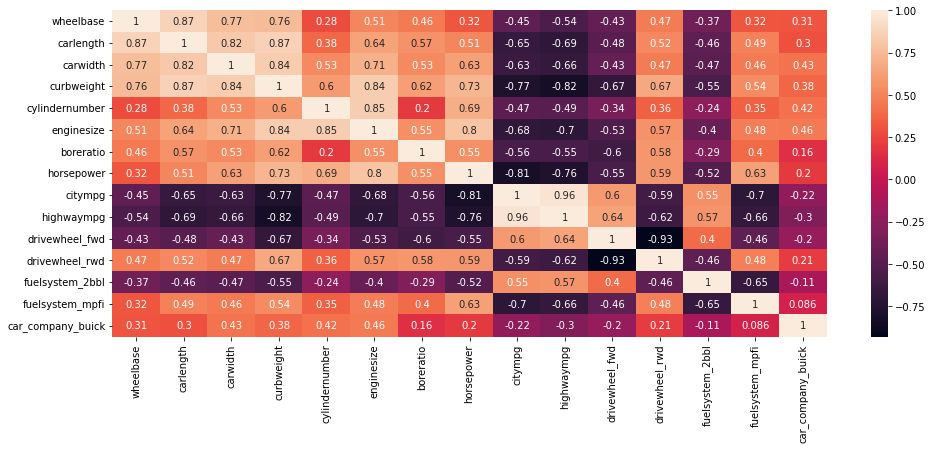

In [13]:
# S1.2: Create a heatmap to visualise the correlation between the above features (if there exists).
plt.figure(figsize=(16,6))
sns.heatmap(X_train[major_features.keys()].corr(),annot=True)
plt.show()

There are a lot of features that are highly correlated. This means there is high probability of multicollinearity.

Now, you know that these are the features that affect the price of a car the most. Hence, you should choose the best ones among these features such that they significantly contribute in predicting the price of a car and there is negligible multicollinearity between them. For this, you can use recursive feature elimination technique.


---

#### Task 2: Recursive Feature Elimination (RFE)

**Recursive feature elimination (RFE)** is a feature selection (or elimination) method that fits a model and removes the weakest feature (or features). Here, you need to decide the number of features you want to select to build a model. Then you can validate your choice of a number of features and increase or decrease them (if required). Features are ranked by the model's `coef_` or `feature_importances_` attributes, and by recursively eliminating a small number of features per loop, RFE attempts to eliminate dependencies and collinearity that may exist in a machine learning model.

RFE requires a specified number of features to keep, however it is often not known in advance how many features are valid.

Let's understand this concept with the help of an example. Let's select the best 10 features out of the highly correlated features that you just stored in the dictionary above.

To use RFE, you need to follow these steps:

1. Import the `RFE` class from the `sklearn.feature_selection` module.

2. Create an object of a `LinearRegression` class. Let's name it `skl_lin_reg`.

3. Create an object of the `RFE` class. Let's name it `rfe1`. The constructor of the `RFE` object takes the object of `LinearRegression` class (i.e. `skl_lin_reg`) and the number of features to be selected using RFE as inputs.

4. Call the `fit()` function on the `RFE` object with the train set (separate sets for independent variables and dependent variable) as input to the function.

5. Use the `support_` attribute of the `RFE` class to get an array containing boolean values wherein `True` denotes the feature selected by RFE. 

6. You can also use the `ranking_` attribute of the `RFE` class to get the rankings of the features. The features selected by `RFE` are ranked $1$.

In [14]:
# S2.1: Use RFE to eliminate few features from the dataset.
# Import RFE.
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
# RFE with 10 features.
sk_lin_reg=LinearRegression()
rfe1=RFE(sk_lin_reg,n_features_to_select=10)
# Fit with 10 features.
rfe1.fit(X_train[major_features.keys()],y_train)
# Print the attributes.
print(f'Major Features:{major_features.keys()}\nRFE:{rfe1.support_}\nRFE rank:{rfe1.ranking_}')

Major Features:dict_keys(['wheelbase', 'carlength', 'carwidth', 'curbweight', 'cylindernumber', 'enginesize', 'boreratio', 'horsepower', 'citympg', 'highwaympg', 'drivewheel_fwd', 'drivewheel_rwd', 'fuelsystem_2bbl', 'fuelsystem_mpfi', 'car_company_buick'])
RFE:[False False  True False  True  True  True  True  True  True  True False
 False  True  True]
RFE rank:[5 3 1 4 1 1 1 1 1 1 1 6 2 1 1]


As you can see, the features having the corresponding `True` or `1` values are the ones selected by RFE. 

Let's print these features.

In [15]:
# S2.2: Print the 10 features selected by RFE in the previous step.
rfe1_features=X_train[major_features.keys()].columns[rfe1.support_]
print(rfe1_features)

Index(['carwidth', 'cylindernumber', 'enginesize', 'boreratio', 'horsepower',
       'citympg', 'highwaympg', 'drivewheel_fwd', 'fuelsystem_mpfi',
       'car_company_buick'],
      dtype='object')


Now, let's build a linear regression model using the `statsmodels.api` module and validate the significance (by calculating the p-values and VIF values) of the 10 features selected.

In [16]:
# S2.3: Build a linear regression model using the 'statsmodels.api' module having the above 10 features selected using RFE.
# Import the 'statsmodels.api' module.
import statsmodels.api as sm
# Subset the train set such that it contains only the above 10 selected features.
X_train_rfe1=X_train[rfe1_features]
# Add the 'const' column to the features set.
X_train_rfe1_sm=sm.add_constant(X_train_rfe1)
# Fit the model with 10 features selected by RFE.
sm_lr=sm.OLS(y_train,X_train_rfe1_sm).fit()
print(sm_lr.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     91.03
Date:                Fri, 04 Feb 2022   Prob (F-statistic):           3.16e-54
Time:                        06:52:35   Log-Likelihood:                -1336.8
No. Observations:                 143   AIC:                             2696.
Df Residuals:                     132   BIC:                             2728.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1.412e+04    618.02

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


We can ignore the warning as it is only an assumption of the OLS model.

The $R^2$ and adjusted $R^2$ values are close to $1$ which is a good sign. However, the p-values for a few features are greater than 0.05 which is not a good sign. So let's also calculate the VIF values before you further eliminate more features:

In [17]:
# S2.4: Check for the VIF values of the 10 features selected by RFE above. 
from statsmodels.stats.outliers_influence import variance_inflation_factor 
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif=pd.DataFrame()
vif['features']=X_train_rfe1_sm.columns
vif['vif']=[variance_inflation_factor(X_train_rfe1_sm.values,i) for i in range(X_train_rfe1_sm.shape[1])]
vif['vif']=round(vif['vif'],2)
vif=vif.sort_values(by='vif',ascending=False)
vif

,features,vif
6,citympg,19.90
7,highwaympg,17.69
3,enginesize,10.13
2,cylindernumber,6.79
0,const,6.53
5,horsepower,6.06
4,boreratio,2.89
1,carwidth,2.50
8,drivewheel_fwd,2.14
9,fuelsystem_mpfi,2.07


Here, you can see that a couple of features have high VIF values which means there's a high probability of multicollinearity even though the `statsmodels.api` didn't throw a multicollinearity warning message. You need to remove this multicollinearity either by one-by-one eliminating features or by selecting the fewer features. Let's go with the latter approach.


**Note:** Let's further eliminate the features with help of the following steps:

1. Calculate the number of features having high p-values. Let's say this is 5.

2. Calculate the number of features having high VIF values. Let's say this is 3. 

3. Consider $\text{max}\{5, 3\} = 5$ in this case. The number of features to be further eliminated would be the maximum of the numbers obtained in steps 1 and 2.

In [18]:
# S2.5: Use RFE to select only 5 features to predict the price of a car.
# RFE with 5 features.
sk_lin_reg1=LinearRegression()
rfe2=RFE(sk_lin_reg,n_features_to_select=5)
# Fit with 10 features.
rfe2.fit(X_train[major_features.keys()],y_train)
# Print the attributes.
print(f'Major Features:{major_features.keys()}\nRFE:{rfe2.support_}\nRFE rank:{rfe2.ranking_}')

# Fit with 5 features.


# Print the attributes.


Major Features:dict_keys(['wheelbase', 'carlength', 'carwidth', 'curbweight', 'cylindernumber', 'enginesize', 'boreratio', 'horsepower', 'citympg', 'highwaympg', 'drivewheel_fwd', 'drivewheel_rwd', 'fuelsystem_2bbl', 'fuelsystem_mpfi', 'car_company_buick'])
RFE:[False False  True False False  True False  True False False  True False
 False False  True]
RFE rank:[10  8  1  9  3  1  4  1  6  5  1 11  7  2  1]


In [19]:
# S2.6: Print the 5 features selected by RFE in the previous step.
rfe2_features=X_train[major_features.keys()].columns[rfe2.support_]
rfe2_features

Index(['carwidth', 'enginesize', 'horsepower', 'drivewheel_fwd',
       'car_company_buick'],
      dtype='object')

Now build the linear regression model again using the most recently selected features by RFE. Use the `statsmodels.api` module to build the linear regression model.

In [21]:
# S2.7: Build the linear regression model again using the most recently selected features by RFE
X_train_rfe2=X_train[rfe2_features]
# Add the 'const' column to the features set.
X_train_rfe2_sm=sm.add_constant(X_train_rfe2)
# Fit the model with 5 features selected by RFE.
sm_lr=sm.OLS(y_train,X_train_rfe2_sm).fit()
print(sm_lr.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     180.2
Date:                Fri, 04 Feb 2022   Prob (F-statistic):           2.00e-58
Time:                        07:02:03   Log-Likelihood:                -1339.8
No. Observations:                 143   AIC:                             2692.
Df Residuals:                     137   BIC:                             2709.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1.436e+04    427.39

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


As you can see, the $R^2$ and adjusted $R^2$ values are pretty high. The p-values for all the 5 features selected are less than 0.05. These are great signs. Now let's calculate the VIF values for these 5 features to see if there is negligible multicollinearity.

In [22]:
# S2.8: Check for the VIF values of the feature variables. 
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif=pd.DataFrame()
vif['features']=X_train_rfe2_sm.columns
vif['vif']=[variance_inflation_factor(X_train_rfe2_sm.values,i) for i in range(X_train_rfe2_sm.shape[1])]
vif['vif']=round(vif['vif'],2)
vif=vif.sort_values(by='vif',ascending=False)
vif

,features,vif
2,enginesize,4.18
3,horsepower,3.35
0,const,3.11
1,carwidth,2.16
4,drivewheel_fwd,1.49
5,car_company_buick,1.46


As you can see, the VIF values for all the features is less than 10. Hence, we can safely assume that the multicollinearity between these features is negligible.

Let's stop here. In the next class, we will evaluate this linear regression model further using the MAE, MSE, RMSE parameters and also analyse the residuals.

---